# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10-11

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
# !pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


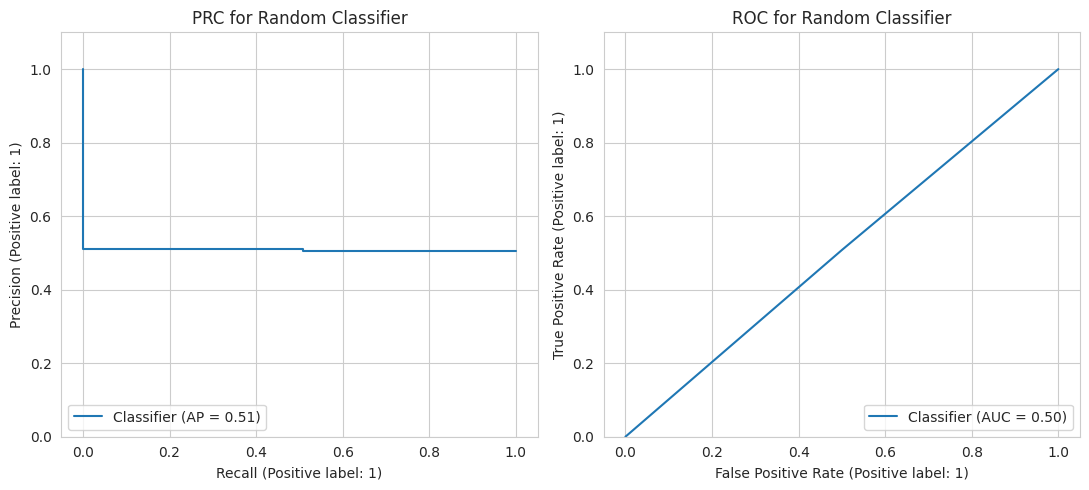

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [8]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [6]:
from sklearn.metrics import average_precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [10]:
pipe_svm = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('linear_svc', LinearSVC())
])

param_grid = {'linear_svc__C' : np.logspace(-4, 3, 10)}
search_svm = GridSearchCV(pipe_svm, param_grid, scoring='average_precision', n_jobs=5)
search_svm.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_svm.best_params_}')
print(f'Having AUC-PR score = {search_svm.best_score_}')

/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/si

Best param found by GridSearchCV: {'linear_svc__C': 0.0005994842503189409}
Having AUC-PR score = 0.8246588157684883


/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
pipe_svm.set_params(**search_svm.best_params_)
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=0.0005994842503189409))])

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [7]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [13]:
def plot_precision_recall_curve(y, y_score):
    precision, recall, _ = precision_recall_curve(y, y_score)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    plt.show()


def plot_roc_curve(y, y_score):
    fpr, tpr, _ = roc_curve(y, y_score)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='purple')

    ax.set_title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()


def plot_pr_roc_curves(y, y_score):
    precision, recall, _ = precision_recall_curve(y, y_score)
    fpr, tpr, _ = roc_curve(y, y_score)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(recall, precision, color='purple')
    axs[0].set_title('Precision-Recall Curve')
    axs[0].set_ylabel('Precision')
    axs[0].set_xlabel('Recall')

    axs[1].plot(fpr, tpr, color='purple')
    axs[1].set_title('ROC Curve')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_xlabel('False Positive Rate')

    plt.show()


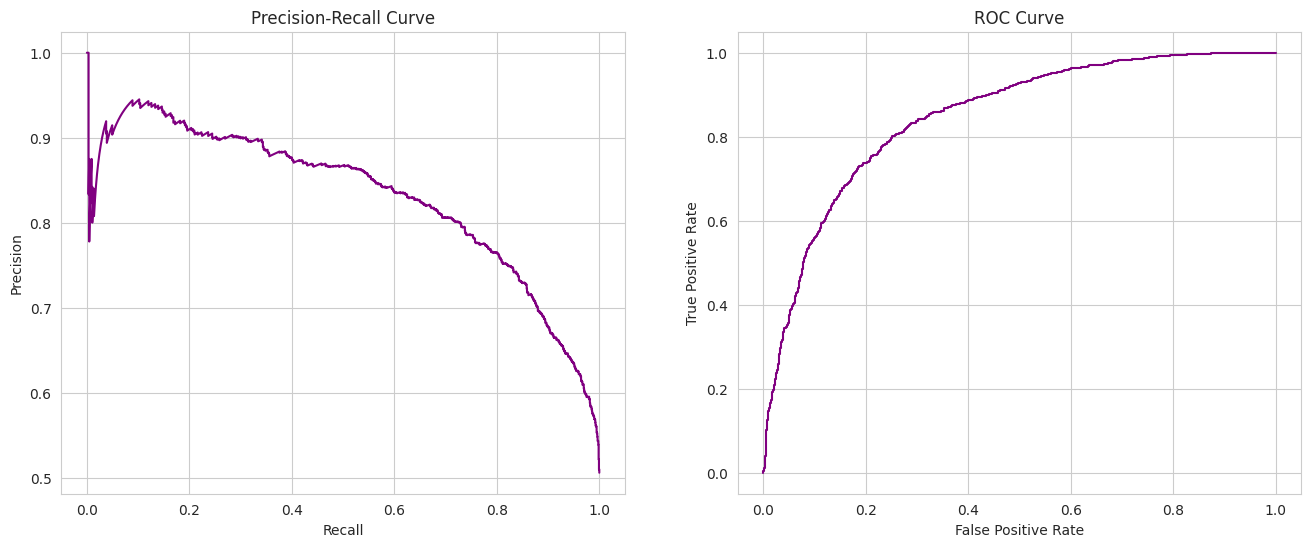

In [14]:
y_test_score = pipe_svm.decision_function(X_test)
plot_pr_roc_curves(y_test, y_test_score)

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_test_score)
fpr, tpr, _ = roc_curve(y_test, y_test_score)

print('AUC-PR: %.5f' % auc(recall, precision))
print('AUC-ROC: %.5f' % auc(fpr, tpr))

AUC-PR: 0.83107
AUC-ROC: 0.84687


In [16]:
df_metrics.loc['LinearSVC'] = [
    auc(recall, precision),
    auc(fpr, tpr),
    None
]

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [17]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
LinearSVC,0.831066,0.846871,NaN


__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [18]:
pipe_lr = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty='l2'))
])

param_grid = {'logistic_regression__C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(pipe_lr, param_grid, scoring='average_precision', n_jobs=5)
search_lr.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')

Best param found by GridSearchCV: {'logistic_regression__C': 0.003593813663804626}
Having AUC-PR score = 0.8242234864115154


In [19]:
pipe_lr.set_params(**search_lr.best_params_)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=0.003593813663804626))])

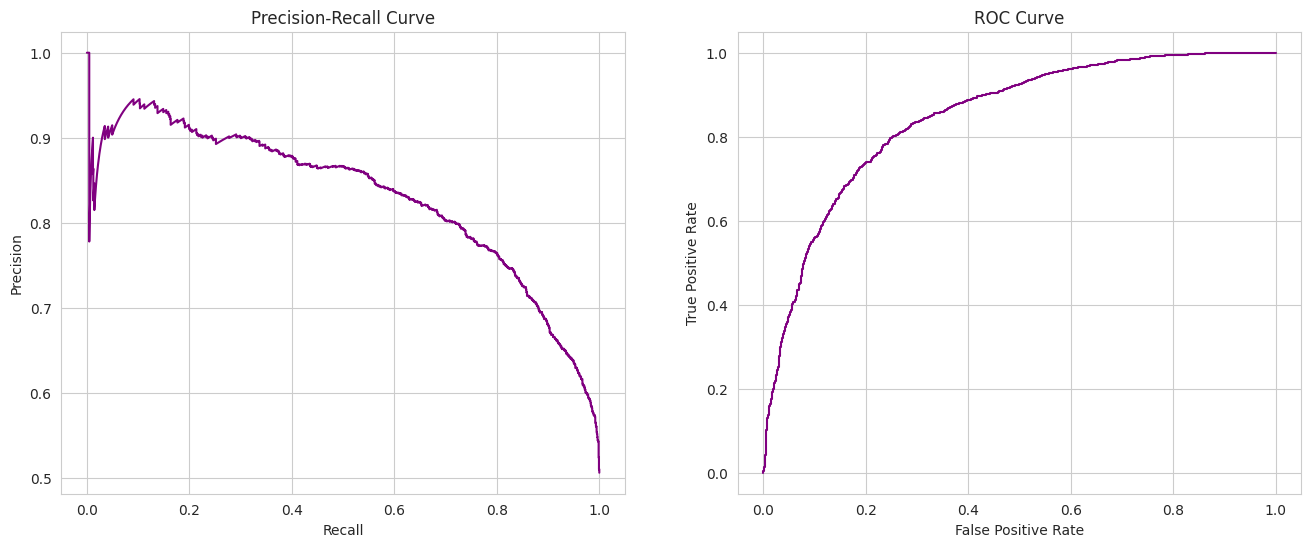

In [20]:
y_test_score = pipe_lr.decision_function(X_test)
plot_pr_roc_curves(y_test, y_test_score)

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_test_score)
fpr, tpr, _ = roc_curve(y_test, y_test_score)

print('AUC-PR: %.5f' % auc(recall, precision))
print('AUC-ROC: %.5f' % auc(fpr, tpr))

AUC-PR: 0.83075
AUC-ROC: 0.84633


In [22]:
df_metrics.loc['Logistic Regression'] = [
    auc(recall, precision),
    auc(fpr, tpr),
    None
]

df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
LinearSVC,0.831066,0.846871,NaN
Logistic Regression,0.830747,0.846332,NaN


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: Различий между ними практически нет, где-то капельку больше AUC-PR, где-то - AUC-ROC.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [22]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, class_sep=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.svm import SVC
import seaborn as sns

In [24]:
model_svm = SVC(kernel='linear')

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_svm = GridSearchCV(model_svm, param_grid, scoring='average_precision', n_jobs=5)
search_svm.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_svm.best_params_}')
print(f'Having AUC-PR score = {search_svm.best_score_}')

model_svm.set_params(**search_svm.best_params_)

Best param found by GridSearchCV: {'C': 166.81005372000593}
Having AUC-PR score = 0.9922832622691985


SVC(C=166.81005372000593, kernel='linear')

In [25]:
model_svm.fit(X_train, y_train)

SVC(C=166.81005372000593, kernel='linear')

In [26]:
def plot_svc(classifier, X, y):
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.scatterplot(
        x = X[:, 0],
        y = X[:, 1],
        hue = y,
        ax = ax
    )

    sns.scatterplot(
        x = classifier.support_vectors_[:, 0],
        y = classifier.support_vectors_[:, 1],
        hue = y[classifier.support_],
        palette=["lightgreen", "plum"]
    )

    w = classifier.coef_[0]
    b = classifier.intercept_[0]
    x0_line = np.linspace(-4, 3)
    x1_line = -(w[0] / w[1]) * x0_line - (b / w[1])

    shift = w / np.inner(w, w)

    x0_line_below, x1_line_below = x0_line - shift[0], x1_line - shift[1]
    x0_line_above, x1_line_above = x0_line + shift[0], x1_line + shift[1]

    sns.lineplot(x=x0_line, y=x1_line, color='red', ax=ax)
    sns.lineplot(x=x0_line_below, y=x1_line_below, color='green', ax=ax)
    sns.lineplot(x=x0_line_above, y=x1_line_above, color='purple', ax=ax)

    ax.set_title('Support Vector Classification')

    # plt.legend(title='', loc='upper right', labels=['lower', 'middle', 'upper', '', '0', '1', 'sv_0', 'sv_1', '0', '1' ])
    plt.show()


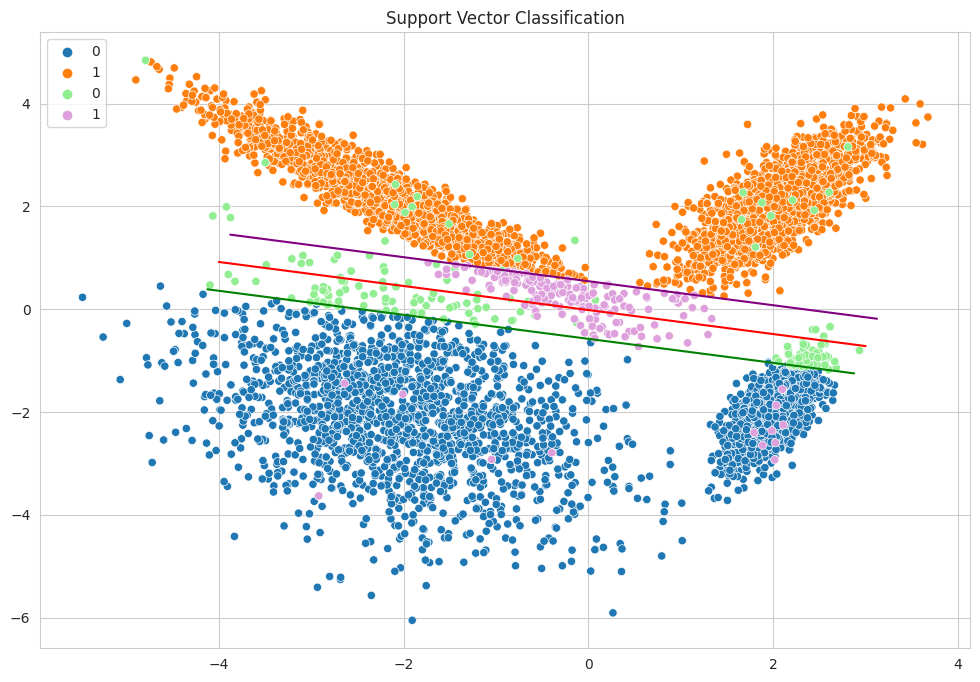

In [27]:
plot_svc(model_svm, X_train, y_train)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [28]:
model_lr = LogisticRegression(penalty='l2')

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)
search_lr.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')

model_lr.set_params(**search_lr.best_params_)
model_lr.fit(X_train, y_train)

Best param found by GridSearchCV: {'C': 4.641588833612782}
Having AUC-PR score = 0.9922042335408735


LogisticRegression(C=4.641588833612782)

In [29]:
def plot_lr_probas(classifier, X, y, grid_size=100, plot_margin_size=0.5):
    y_predict = classifier.predict(X)

    x0_min, x0_max = X[:, 0].min(), X[:, 0].max()
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()

    x0_margins = (x0_min - plot_margin_size, x0_max + plot_margin_size)
    x1_margins = (x1_min - plot_margin_size, x1_max + plot_margin_size)

    x0_grid, x1_grid = np.meshgrid(np.linspace(x0_margins[0], x0_margins[1], grid_size),
                                   np.linspace(x1_margins[0], x1_margins[1], grid_size).T)

    x0_grid, x1_grid = x0_grid.ravel(), x1_grid.ravel()
    x0_grid = x0_grid.reshape((x0_grid.shape[0], 1))
    x1_grid = x1_grid.reshape((x1_grid.shape[0], 1))

    X_grid = np.concatenate((x0_grid, x1_grid), axis=1)
    # 1-st column is linspace repeated grid_size times
    # 2-nd column is each element of linspace repeated grid_size times
    # so each pair of (x0, x1) is inside the X_grid

    probas = classifier.predict_proba(X_grid)

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title('Logistic Regression Probability Distribution', fontdict={'fontsize': 14})
    im = plt.imshow(probas[:, 1].reshape((grid_size, grid_size)),
                            extent=(*x0_margins, *x1_margins), origin='lower', cmap='Spectral')
    plt.xticks(())
    plt.yticks(())

    pos_class_indexes = (y_predict == 1)
    plt.scatter(X[:, 0], X[:, 1], c='pink', edgecolors='purple')
    plt.scatter(X[pos_class_indexes, 0], X[pos_class_indexes, 1], c='lightblue', edgecolors='blue')

    # ax = plt.axes([0.15, 0.04, 0.7, 0.05])
    bar_ax = plt.axes([0.82, 0.2, 0.03, 0.5])
    plt.title('probability')
    plt.colorbar(im, cax=bar_ax, orientation='vertical')

    plt.show()


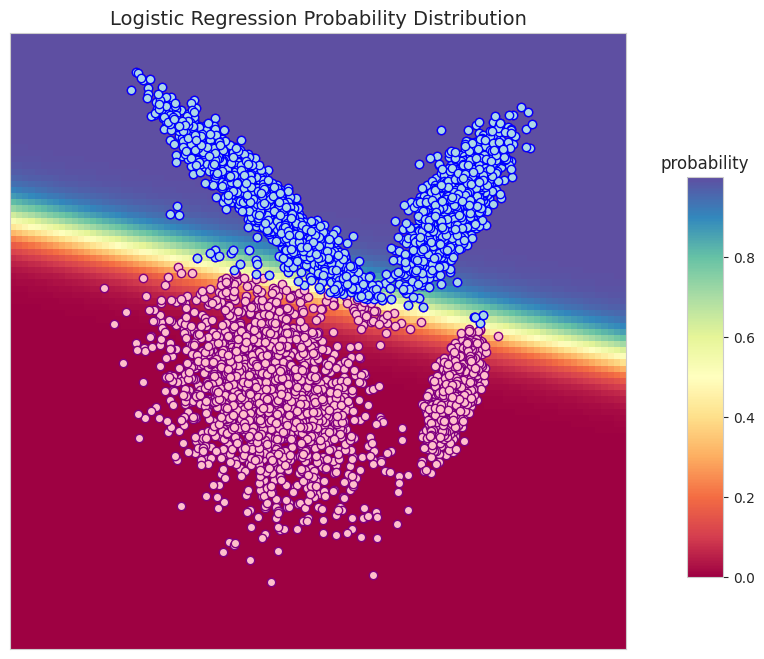

In [30]:
plot_lr_probas(model_lr, X_train, y_train, plot_margin_size=2)

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [64]:
def plot_calibration_curve(y_test, predicts, labels=None, n_bins=15):
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

    if labels is None:
        labels = [''] * len(predicts)

    for predict in predicts:
        bin_middle_points = []
        bin_real_ratios = []

        for i in range(n_bins):
            l = 1.0 / n_bins * i
            r = 1.0 / n_bins * (i + 1)
            bin_middle_points.append((l + r) / 2)
            predict_batch = y_test[(predict >= l) & (predict < r)]
            bin_real_ratios.append(np.sum(predict_batch) / predict_batch.shape[0])

        plt.plot(bin_middle_points, bin_real_ratios)
        plt.ylim([-0.05, 1.05])

    plt.legend(labels=(['ideal'] + labels))
    plt.title('Calibration Curves')
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [58]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
model_svm = SVC(kernel='linear', probability=True)

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_svm = GridSearchCV(model_svm, param_grid, scoring='average_precision', n_jobs=5)
search_svm.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_svm.best_params_}')
print(f'Having AUC-PR score = {search_svm.best_score_}')

model_svm.set_params(**search_svm.best_params_)
model_svm.fit(X_train, y_train)

Best param found by GridSearchCV: {'C': 0.0001}
Having AUC-PR score = 0.8280316049835692


SVC(C=0.0001, kernel='linear', probability=True)

In [60]:
model_lr = LogisticRegression(penalty='l2')

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)
search_lr.fit(X_train, y_train)

print(f'Best param found by GridSearchCV: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')

model_lr.set_params(**search_lr.best_params_)
model_lr.fit(X_train, y_train)

Best param found by GridSearchCV: {'C': 0.0005994842503189409}
Having AUC-PR score = 0.8285198251443257


LogisticRegression(C=0.0005994842503189409)

In [61]:
def get_svc_probas_for_curve(model, X):
    svc_probas = model.predict_proba(X)[:, 1]
    return (svc_probas - svc_probas.min()) / (svc_probas.max() - svc_probas.min())

def get_lr_probas_for_curve(model, X):
    return model.predict_proba(X)[:, 1]

In [62]:
svc_probas = get_svc_probas_for_curve(model_svm, X_test)
svc_decision_function = model_svm.decision_function(X_test)
lr_probas = get_lr_probas_for_curve(model_lr, X_test)
lr_decision_function = model_lr.decision_function(X_test)

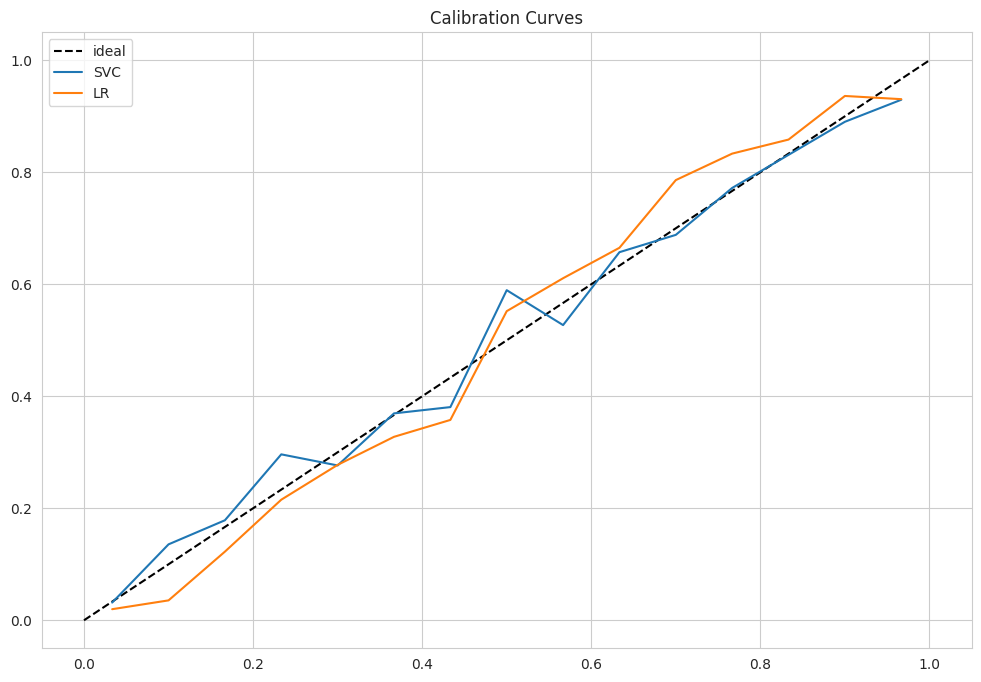

In [65]:
plot_calibration_curve(
    y_test,
    predicts=[svc_probas, lr_probas],
    labels=['SVC', 'LR']
)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

In [66]:
def plot_two_distributions(x, y, title='', dist_titles=[]):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    axs[0].hist(x, bins=20, color='lightgreen', density='True')
    axs[1].hist(y, bins=20, color='salmon', density='True')

    axs[0].set_title(dist_titles[0] if dist_titles else '')
    axs[1].set_title(dist_titles[1] if dist_titles else '')

    plt.suptitle(title)
    plt.show()


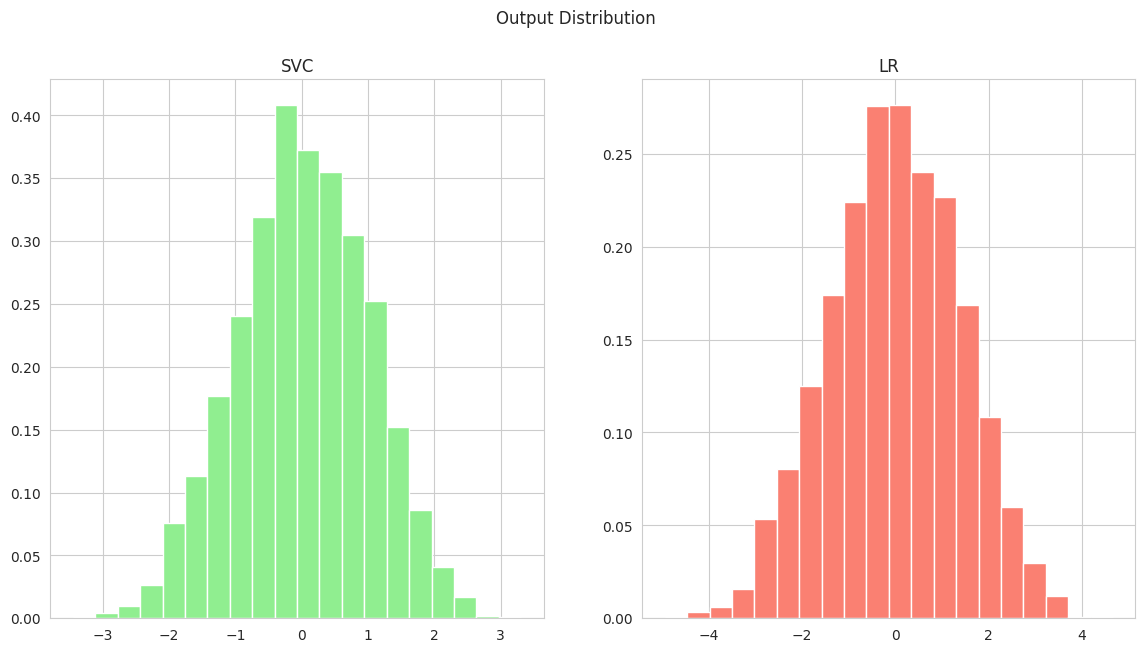

In [67]:
plot_two_distributions(
    svc_decision_function,
    lr_decision_function,
    title='Output Distribution',
    dist_titles=['SVC', 'LR']
)


Чем они различаются? Чем вы можете объяснить это?

Ответ: логистическая регрессия существенно менее уверенная

In [ ]:
#your code here

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [71]:
from sklearn.calibration import CalibratedClassifierCV

In [72]:
model_svm = SVC(kernel='linear', probability=True, C=0.0001)
model_svm.fit(X_train, y_train)
calibrated_svm = CalibratedClassifierCV(base_estimator=model_svm, cv=3)
calibrated_svm.fit(X_test, y_test)

CalibratedClassifierCV(base_estimator=SVC(C=0.0001, kernel='linear',
                                          probability=True),
                       cv=3)

In [73]:
model_lr = LogisticRegression(penalty='l2', C=0.0006)
model_lr.fit(X_train, y_train)
calibrated_lr = CalibratedClassifierCV(base_estimator=model_lr, cv=3)
calibrated_lr.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.0006), cv=3)

In [74]:
svc_probas_calibrated = get_svc_probas_for_curve(calibrated_svm, X_test)
lr_probas_calibrated = get_lr_probas_for_curve(calibrated_lr, X_test)

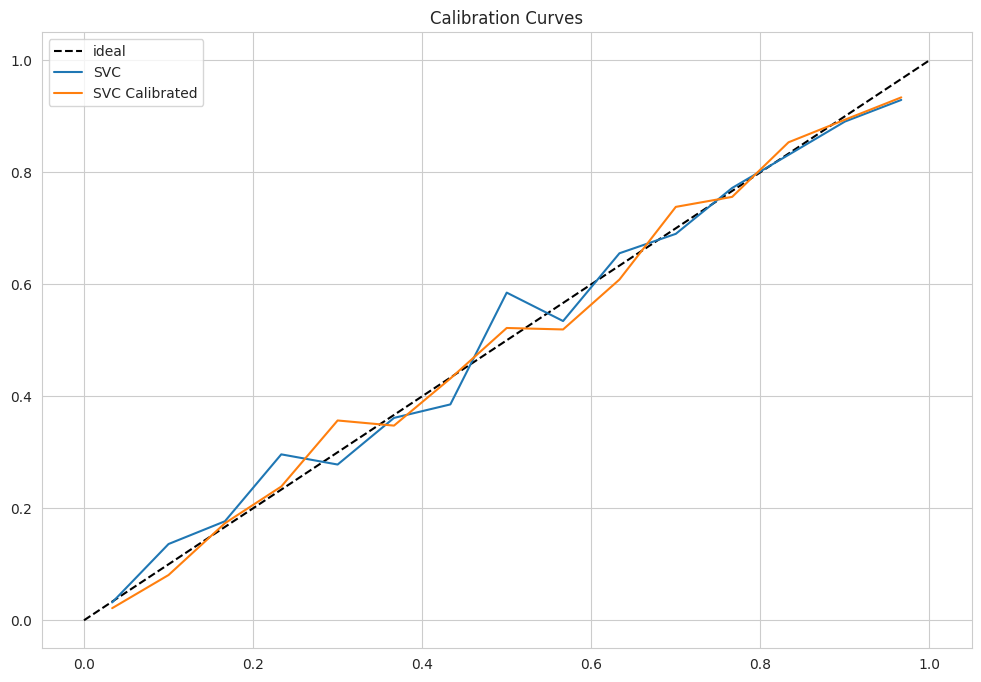

In [45]:
plot_calibration_curve(
    y_test,
    predicts=[svc_probas, svc_probas_calibrated],
    labels=['SVC', 'SVC Calibrated']
)

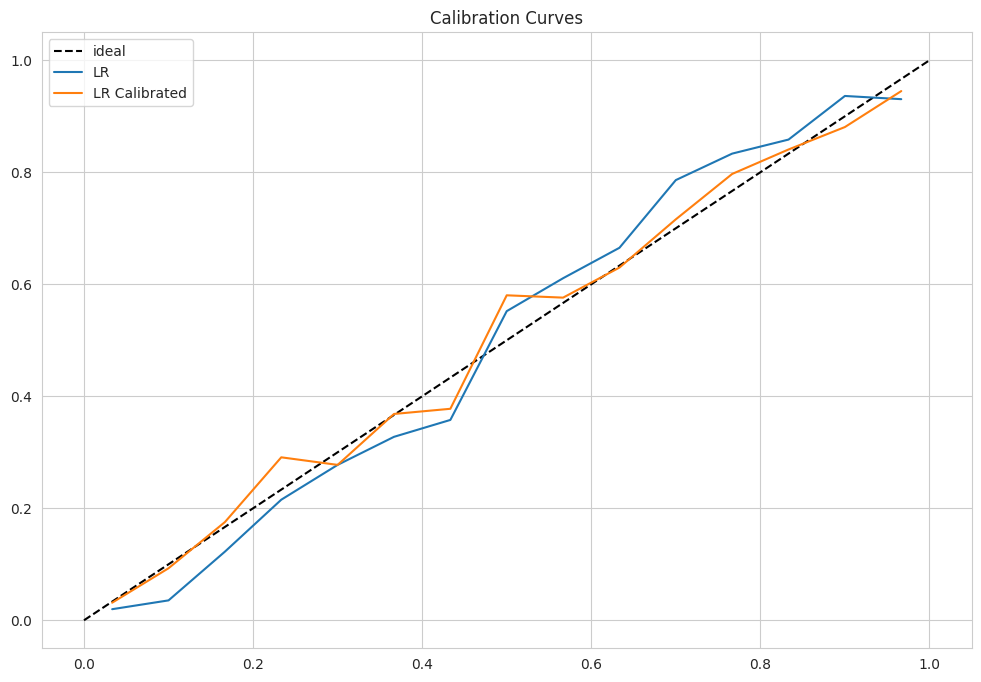

In [46]:
plot_calibration_curve(
    y_test,
    predicts=[lr_probas, lr_probas_calibrated],
    labels=['LR', 'LR Calibrated']
)

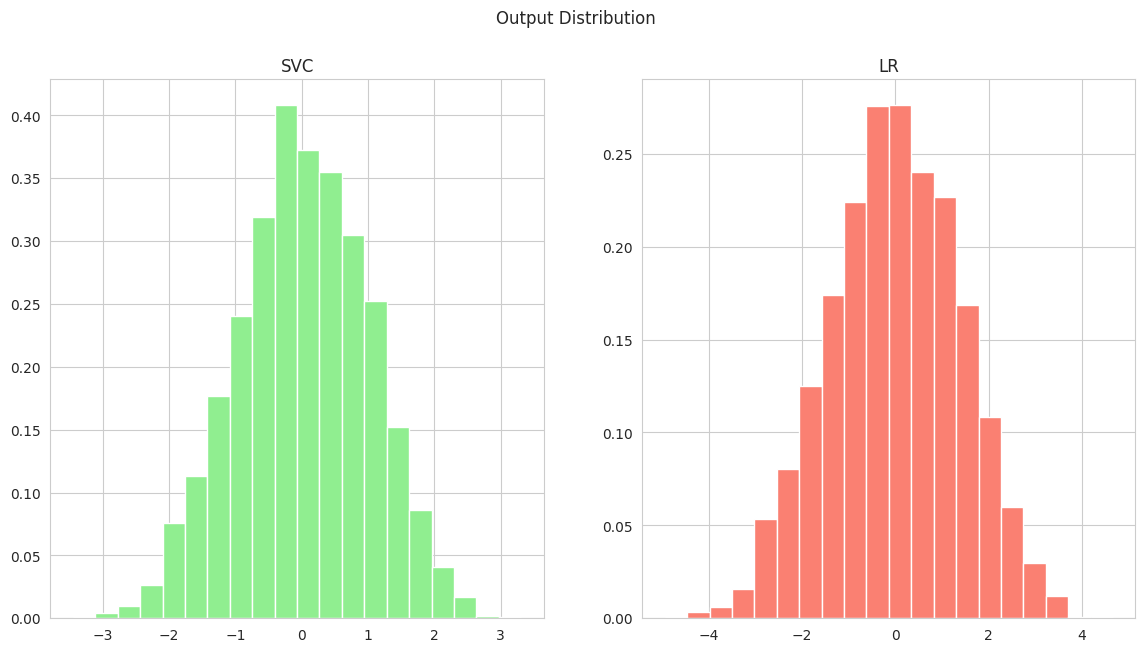

In [68]:
plot_two_distributions(
    svc_decision_function,
    lr_decision_function,
    title='Output Distribution',
    dist_titles=['SVC', 'LR']
)

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

class PlattCalibrationClassifier(BaseEstimator, TransformerMixin):
    '''Trains model on train, then calibrates on test it using Platt Calibration.'''
    def __init__(self, base_estimator):
        self.clf = base_estimator
        self.calibration_model = LogisticRegression()

    def fit(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        train_probas = self.clf.predict_proba(X_train)[:, 1].reshape(-1, 1)
        self.calibration_model.fit(train_probas, y_train)

    def predict(self, X_test):
        probas = self.clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
        probas_calibrated = self.calibration_model.predict_proba(probas)
        return np.sign(probas_calibrated - 0.5)

    def decision_function(self, X_test):
        decision_function = self.clf.decision_function(X_test).reshape(-1, 1)
        return self.calibration_model.decision_function(decision_function)

    def predict_proba(self, X_test):
        test_probas = self.clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
        return self.calibration_model.predict_proba(test_probas)


In [85]:
calibrated_platt_svm = PlattCalibrationClassifier(base_estimator=model_svm)
calibrated_platt_svm.fit(X_train, y_train)

In [81]:
svc_probas_platt = get_svc_probas_for_curve(calibrated_platt_svm, X_test)

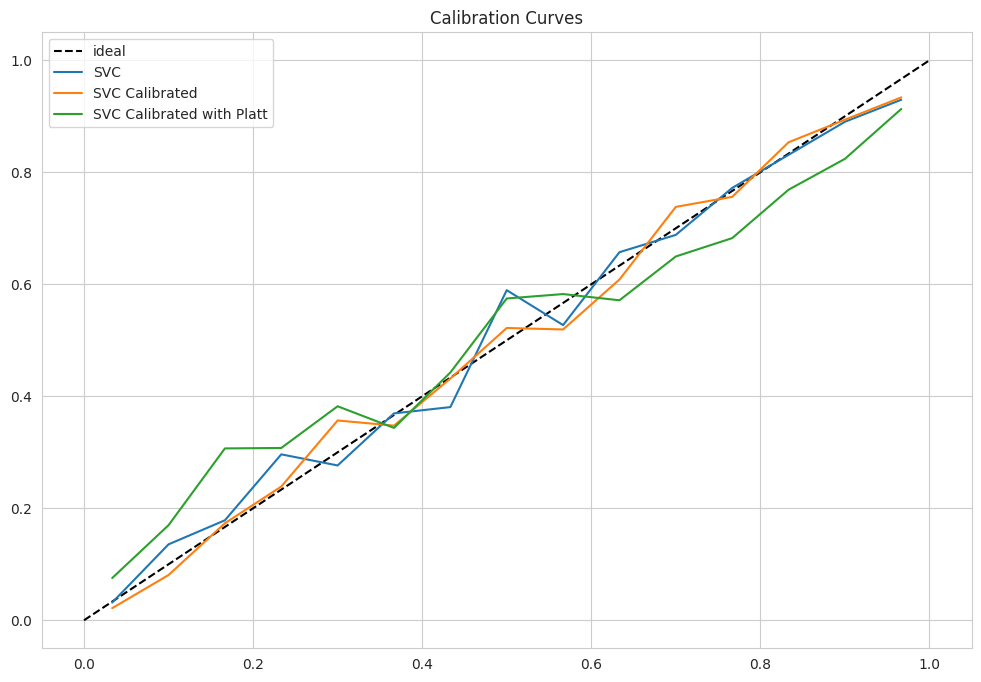

In [82]:
plot_calibration_curve(
    y_test,
    predicts=[svc_probas, svc_probas_calibrated, svc_probas_platt],
    labels=['SVC', 'SVC Calibrated', 'SVC Calibrated with Platt']
)

In [86]:
svc_decision_function_platt = calibrated_platt_svm.decision_function(X_test)

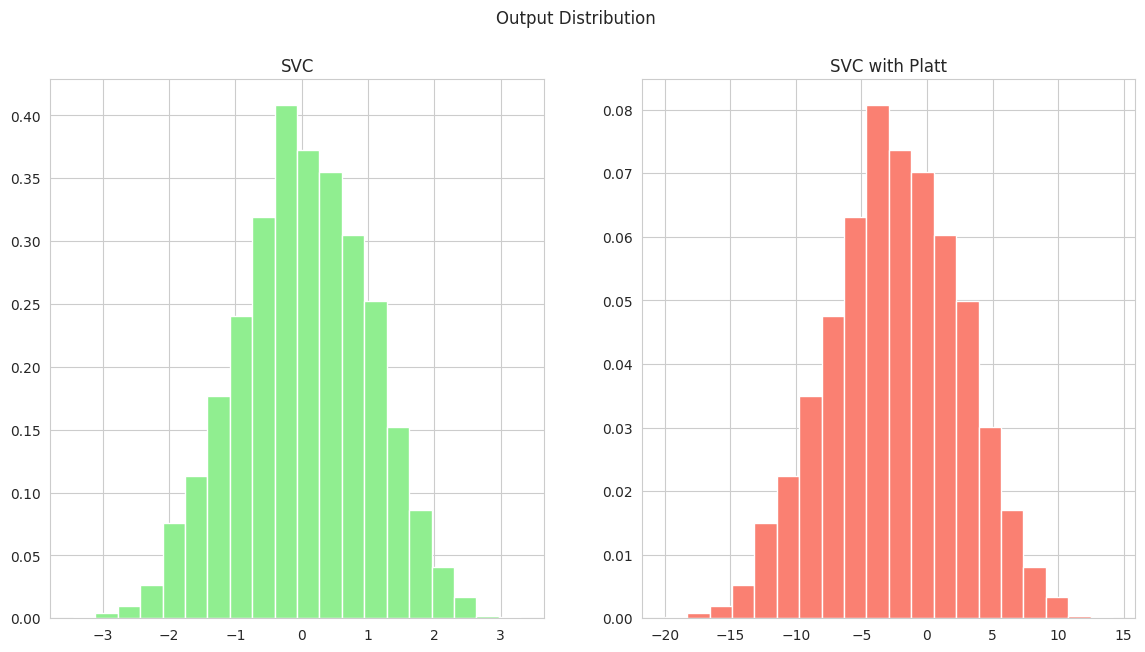

In [94]:
plot_two_distributions(
    svc_decision_function,
    svc_decision_function_platt,
    title='Output Distribution',
    dist_titles=['SVC', 'SVC with Platt']
)

In [89]:
model_lr = LogisticRegression(penalty='l2', C=0.00059)

In [91]:
calibrated_platt_lr = PlattCalibrationClassifier(base_estimator=model_lr)
calibrated_platt_lr.fit(X_train, y_train)

In [92]:
lr_probas_platt = get_lr_probas_for_curve(calibrated_platt_lr, X_test)

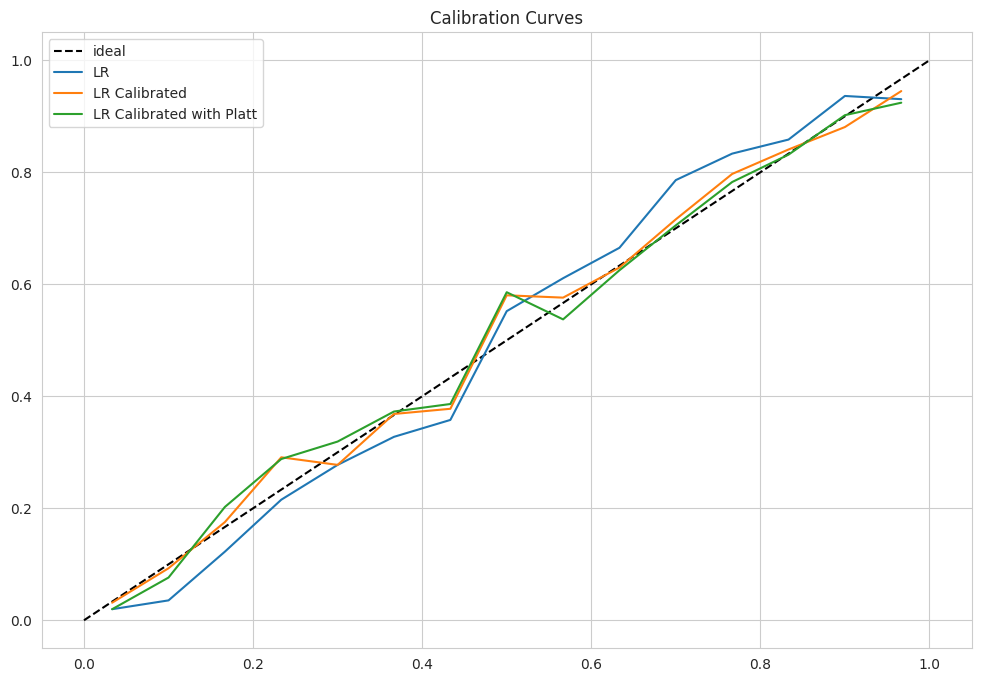

In [93]:
plot_calibration_curve(
    y_test,
    predicts=[lr_probas, lr_probas_calibrated, lr_probas_platt],
    labels=['LR', 'LR Calibrated', 'LR Calibrated with Platt']
)

In [95]:
lr_decision_function_platt = calibrated_platt_lr.decision_function(X_test)

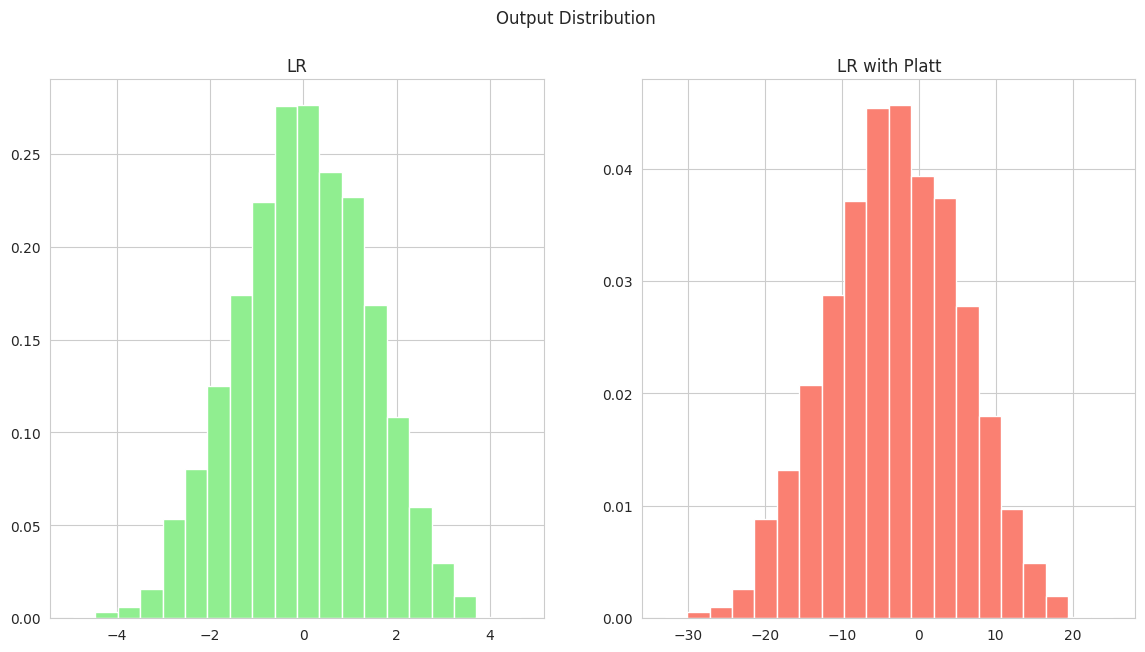

In [96]:
plot_two_distributions(
    lr_decision_function,
    lr_decision_function_platt,
    title='Output Distribution',
    dist_titles=['LR', 'LR with Platt']
)

SVC Platt только сделал хуже, LR - вполне норм.

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [37]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-11-16 22:06:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.7’

adult.data.7        100%[===================>]   3.79M   516KB/s    in 9.5s    

2022-11-16 22:06:32 (408 KB/s) - ‘adult.data.7’ saved [3974305/3974305]



In [102]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [103]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,1


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'income'], df.loc[:, 'income'],
    stratify=df.loc[:, 'income'], test_size=0.25, random_state=777
)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [14]:
import time

In [400]:
numeric_features = [
    'age', 'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country'
]

In [352]:
column_transformer = ColumnTransformer([
    ('ordinal_encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline(steps=[
    ('column_transformer', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=300))
])

param_grid = {'logistic_regression__C' : np.logspace(-3, 3, 10)}
search_lr = GridSearchCV(pipe_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(X_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with OrdinalEncoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(X_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Best param found by GridSearchCV with OrdinalEncoding: {'logistic_regression__C': 46.41588833612773}
Having AUC-PR score = 0.6916882651278181
And AUC-PR score on test = 0.6824136540145539
It took 8.780 seconds to run CrossValidation 5 times on such pipe


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: # your answer here

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [353]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline(steps=[
    ('column_transformer', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=500))
])

param_grid = {'logistic_regression__C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(pipe_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(X_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(X_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by GridSearchCV with One-Hot-Encoding: {'logistic_regression__C': 0.774263682681127}
Having AUC-PR score = 0.7671773250045014
And AUC-PR score on test = 0.7673243590159307
It took 8.999 seconds to run CrossValidation 5 times on such pipe


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [12]:
from category_encoders import TargetEncoder

In [355]:
column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline(steps=[
    ('column_transformer', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=500))
])

param_grid = {'logistic_regression__C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(pipe_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(X_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(X_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/ca

Best param found by GridSearchCV with One-Hot-Encoding: {'logistic_regression__C': 0.774263682681127}
Having AUC-PR score = 0.7587735281033344
And AUC-PR score on test = 0.755937796261488
It took 6.445 seconds to run CrossValidation 5 times on such pipe


In [358]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    '''Trains model on train, then calibrates on test it using Platt Calibration.'''
    def __init__(self, categories):
        self.categories = categories
        self.mean_targets_df = pd.DataFrame(columns=['category', 'value', 'mean_target'])

    def fit(self, X=None, y=None):
        df = X.copy()
        df['income'] = y.copy()
        # df.columns = [*X.columns, 'income']

        for i, category in enumerate(self.categories):
            category_df = df.groupby(category)[['income']].mean()
            category_df.reset_index(inplace=True)
            category_df.columns = ['value', 'mean_target']
            category_df.loc[:, 'category'] = category
            self.mean_targets_df = pd.concat([self.mean_targets_df, category_df], ignore_index=True, copy=False)

        return self

    def replace_with_mean_value(self, x, category):
        # print(self.mean_targets_df.loc[
        #     (self.mean_targets_df['category'] == category) & \
        #     (self.mean_targets_df['value'] == x),
        #     'mean_target'
        # ].iloc[0])
        result = self.mean_targets_df.loc[
            (self.mean_targets_df['category'] == category) & \
            (self.mean_targets_df['value'] == x),
            'mean_target'
        ]
        assert len(result), f'info: {category}, {x}, {result}'
        return result.iloc[0]

    def transform(self, X=None):
        Xt = X.copy()
        # assert False, f'categories: {self.mean_targets.keys()},\nvalues: {df.groupby(category)[[0]].mean()}'
        # assert False, f'{Xt.columns}'

        for category in self.categories:
            # Xt.loc[:, category] = Xt.loc[:, category].map(
            #     lambda x: self.replace_with_mean_value(x, category)
            # )

            # # alternative:
            category_df = self.mean_targets_df.loc[
                self.mean_targets_df['category'] == category
            ]
            assert category_df.shape[0], 'No such category found'

            for _, row in category_df.iterrows():
                Xt.loc[Xt[category] == row['value'], category] = row['mean_target']

        return Xt

mte = MeanTargetEncoder(categorical_features)
mte.fit(X_train, y_train)
Xt_train = mte.transform(X_train)
Xt_test = mte.transform(X_test)
Xt_train.sort_index()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,0.280808,77516,0.409605,13,0.046198,0.138017,0.102748,0.255627,0.305525,2174,0,40,0.246003
1,50,0.286469,83311,0.409605,13,0.446203,0.48252,0.448217,0.255627,0.305525,0,0,13,0.246003
2,38,0.21833,215646,0.16237,9,0.104223,0.071012,0.102748,0.255627,0.305525,0,0,40,0.246003
3,53,0.21833,234721,0.05137,7,0.446203,0.071012,0.448217,0.125266,0.305525,0,0,40,0.246003
4,28,0.21833,338409,0.409605,13,0.446203,0.450308,0.473237,0.125266,0.109456,0,0,40,0.257143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,53,0.21833,321865,0.569884,14,0.446203,0.48252,0.448217,0.255627,0.305525,0,0,40,0.246003
32555,22,0.21833,310152,0.184646,10,0.046198,0.331967,0.102748,0.255627,0.305525,0,0,40,0.246003
32556,27,0.21833,257302,0.254522,12,0.446203,0.291729,0.473237,0.255627,0.109456,0,0,38,0.246003
32557,40,0.21833,154374,0.16237,9,0.446203,0.130859,0.448217,0.255627,0.305525,0,0,40,0.246003


In [359]:
te = TargetEncoder()
te.fit(X_train, y_train)
Xt_te_train = te.transform(X_train)
Xt_te_train.sort_index()

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,0.280808,77516,0.409605,13,0.046198,0.138017,0.102748,0.255627,0.305525,2174,0,40,0.246003
1,50,0.286469,83311,0.409605,13,0.446203,0.482520,0.448217,0.255627,0.305525,0,0,13,0.246003
2,38,0.218330,215646,0.162370,9,0.104223,0.071012,0.102748,0.255627,0.305525,0,0,40,0.246003
3,53,0.218330,234721,0.051370,7,0.446203,0.071012,0.448217,0.125266,0.305525,0,0,40,0.246003
4,28,0.218330,338409,0.409605,13,0.446203,0.450308,0.473237,0.125266,0.109456,0,0,40,0.257143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,53,0.218330,321865,0.569884,14,0.446203,0.482520,0.448217,0.255627,0.305525,0,0,40,0.246003
32555,22,0.218330,310152,0.184646,10,0.046198,0.331967,0.102748,0.255627,0.305525,0,0,40,0.246003
32556,27,0.218330,257302,0.254522,12,0.446203,0.291729,0.473237,0.255627,0.109456,0,0,38,0.246003
32557,40,0.218330,154374,0.162370,9,0.446203,0.130859,0.448217,0.255627,0.305525,0,0,40,0.246003


In [360]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline(steps=[
    ('column_transformer', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=500))
])

param_grid = {'logistic_regression__C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(pipe_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Best param found by GridSearchCV with One-Hot-Encoding: {'logistic_regression__C': 1000.0}
Having AUC-PR score = 0.6536365689174175
And AUC-PR score on test = 0.6490820147693077
It took 1.204 seconds to run CrossValidation 5 times on such pipe


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

РЕАЛИЗОВАЛ ВЫШЕ

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [401]:
train_noise = np.random.normal(0, 0.1, X_train.shape)
test_noise = np.random.normal(0, 0.1, X_test.shape)

column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)
Xt_train += train_noise
Xt_test += test_noise

model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Best param found by GridSearchCV with One-Hot-Encoding: {'C': 166.81005372000593}
Having AUC-PR score = 0.738529608106932
And AUC-PR score on test = 0.7321134353359474
It took 3.006 seconds to run CrossValidation 5 times on such pipe


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [402]:
train_noise = np.random.normal(0, 0.1, X_train.shape)
test_noise = np.random.normal(0, 0.1, X_test.shape)

column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(smoothing=10.0), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)
Xt_train += train_noise
Xt_test += test_noise

model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-2, 5, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Best param found by GridSearchCV with One-Hot-Encoding: {'C': 12.91549665014884}
Having AUC-PR score = 0.7354462895561787
And AUC-PR score on test = 0.7353221982026833
It took 2.192 seconds to run CrossValidation 5 times on such pipe


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [403]:
numeric_features = [
    'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country', 'age'
]

In [405]:
train_noise = np.random.normal(0, 0.1, X_train.shape)
test_noise = np.random.normal(0, 0.1, X_test.shape)

column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(smoothing=10.0), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)
Xt_train += train_noise
Xt_test += test_noise

model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print('Set age as categorical feature')
print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Set age as categorical feature
Best param found by GridSearchCV with One-Hot-Encoding: {'C': 166.81005372000593}
Having AUC-PR score = 0.7345987331645899
And AUC-PR score on test = 0.7319139549984905
It took 8.872 seconds to run CrossValidation 5 times on such pipe


/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Set age as categorical feature
Best param found by GridSearchCV with One-Hot-Encoding: {'C': 4.641588833612782}
Having AUC-PR score = 0.733936788345523
And AUC-PR score on test = 0.734154406105046
It took 8.651 seconds to run CrossValidation 5 times on such pipe


In [99]:
numeric_features = [
    'age', 'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country', 'hours-per-week'
]

In [406]:
train_noise = np.random.normal(0, 0.1, X_train.shape)
test_noise = np.random.normal(0, 0.1, X_test.shape)

column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(smoothing=10.0), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)
Xt_train += train_noise
Xt_test += test_noise

model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print('Set hours-per-week as categorical feature')
print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Set hours-per-week as categorical feature
Best param found by GridSearchCV with One-Hot-Encoding: {'C': 166.81005372000593}
Having AUC-PR score = 0.7369047927235994
And AUC-PR score on test = 0.7292455712458188
It took 7.622 seconds to run CrossValidation 5 times on such pipe


In [376]:
numeric_features = [
    'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country', 'age', 'hours-per-week'
]

In [379]:
train_noise = np.random.normal(0, 0.1, X_train.shape)
test_noise = np.random.normal(0, 0.1, X_test.shape)

column_transformer = ColumnTransformer([
    ('mean_target_encoding', TargetEncoder(smoothing=10.0), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.fit_transform(X_test, y_test)
Xt_train += train_noise
Xt_test += test_noise


model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-2, 5, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print('Set age and hours-per-week as categorical feature')
print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/sergey/.local/lib/python3.10/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


Set age and hours-per-week as categorical feature
Best param found by GridSearchCV with One-Hot-Encoding: {'C': 77.4263682681127}
Having AUC-PR score = 0.7354399971224674
And AUC-PR score on test = 0.7367399402800132
It took 12.890 seconds to run CrossValidation 5 times on such pipe


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [106]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'income'], df.loc[:, 'income'],
    stratify=df.loc[:, 'income'], test_size=0.25, random_state=777
)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [108]:
numeric_features = [
    'age', 'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week'
]
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country'
]

In [19]:
print(X_train.shape)
print(X_test.shape)

(24420, 14)
(8141, 14)


In [20]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

#
Xt_train = column_transformer.fit_transform(X_train, y_train)
Xt_test = column_transformer.transform(X_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')
print(Xt_test.shape)

model_lr = LogisticRegression(max_iter=500)
param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)
(8141, 108)


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 0.774263682681127}
Having AUC-PR score = 0.7671743839948537
And AUC-PR score on test = 0.7673243590159307
It took 9.725 seconds to run CrossValidation 5 times on such pipe


In [21]:
model_lr.set_params(**search_lr.best_params_)

LogisticRegression(C=0.774263682681127, max_iter=500)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [22]:
best_score_ohe_lr = search_lr.best_score_

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [415]:
model_lr.fit(Xt_train, y_train)
model_lr.coef_

array([[-0.0704164 ,  0.69998446, -0.03802038, -0.11378391,  0.2172154 ,
         0.29663197, -0.2546225 , -0.06331121, -0.66961558, -0.11216119,
        -0.26288653, -0.05790311,  0.57908125,  0.60790828,  0.08537175,
         0.03779711, -0.31709068, -0.08238442, -0.05991408,  0.23379073,
        -0.06742537,  0.08567338, -0.87534566,  0.2543736 , -0.04482318,
        -0.47960095,  1.65691015,  1.56608105, -0.67521976, -1.0182764 ,
        -0.76056236, -0.28526987, -0.18420031,  0.18999151, -0.17222083,
         0.22773952,  0.9236808 , -0.94450379, -0.38814412, -0.10022562,
        -0.70068711, -1.36293522,  0.63207801,  0.74872475,  0.41215511,
         0.70100626,  0.02160291, -0.14805451,  0.27738449, -0.57776024,
        -0.85629465,  0.15424642,  1.15454035, -0.34000791,  0.31623294,
         0.01378435, -0.18180671,  0.1958592 , -0.43499564,  0.4390575 ,
         0.01471924,  0.77103718,  0.85410365, -0.14889476, -1.10910618,
         0.45332355, -0.77523204, -0.27165666, -0.4

In [417]:
model_coef = model_lr.coef_
max_coef_abs_features_ind = np.argsort(np.abs(model_coef), axis=1)[:, -40:].reshape(40)
Xt_train_by_abs = Xt_train[:, np.sort(max_coef_abs_features_ind)]
Xt_test_by_abs = Xt_test[:, np.sort(max_coef_abs_features_ind)]
print(f'X_train shape after one-hot-encoding and drop by abs: {Xt_train_by_abs.shape}')

X_train shape after one-hot-encoding and drop by abs: (24420, 40)


In [418]:
param_grid = {'C' : np.logspace(0, 9, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train_by_abs, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test_by_abs, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 10000000.0}
Having AUC-PR score = 0.7396371655342253
And AUC-PR score on test = 0.7320732299363631
It took 7.614 seconds to run CrossValidation 5 times on such pipe


Изменилось ли качество? Как? Стало хуже.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Я везде применял StandardScaler, так что сейчас пробую без него

In [121]:
def fit_transform_column_subset(X_train, y_train, X_test, features, unchanged_features, encoder):
    column_transformer = ColumnTransformer([('', encoder, features)])

    Xtf_train = pd.DataFrame(column_transformer.fit_transform(X_train.loc[:, features], y_train))
    Xt_train = pd.concat([X_train.loc[:, unchanged_features].reset_index(drop=True), Xtf_train], axis=1)

    Xtf_test = pd.DataFrame(column_transformer.transform(X_test.loc[:, features]))
    Xt_test = pd.concat([X_test.loc[:, unchanged_features].reset_index(drop=True), Xtf_test], axis=1)

    return Xt_train, Xt_test

In [122]:
# column_transformer = ColumnTransformer([
#     ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
# ])
#
# Xt_train_cat = pd.DataFrame(
#     column_transformer.fit_transform(X_train.loc[:, categorical_features], y_train)
# )
# print(Xt_train_cat.shape)
#
# Xt_train = pd.concat([
#     X_train.loc[:, numeric_features].reset_index(drop=True),
#     Xt_train_cat
# ], axis=1)
Xt_train, Xt_test = fit_transform_column_subset(
    X_train, y_train, X_test,
    categorical_features,
    numeric_features,
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)


In [123]:
# ohe = OneHotEncoder(handle_unknown='ignore', categories=categorical_features)
# Xt_train = X_train.copy()
# ohe.fit(Xt_train.loc[:, categorical_features], y_train)
# Xt_train.loc[:, categorical_features] = ohe.transform(
#     Xt_train.loc[:, categorical_features]
# )

model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:18

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 0.774263682681127}
Having AUC-PR score = 0.5088867622662617
And AUC-PR score on test = 0.4504242709496442
It took 10.460 seconds to run CrossValidation 5 times on such pipe


/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


без стандардскейлера какой-то кринж

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [53]:
Xt_train, Xt_test = fit_transform_column_subset(
    X_train, y_train, X_test,
    categorical_features,
    numeric_features,
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
Xt_train, Xt_test = fit_transform_column_subset(
    Xt_train, y_train, Xt_test,
    Xt_train.columns,
    [],
    StandardScaler()
)

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)


/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [44]:
import time

In [54]:
model_lr = LogisticRegression(max_iter=500)

param_grid = {'C' : np.logspace(0, 9, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 100000.0}
Having AUC-PR score = 0.7662475713086259
And AUC-PR score on test = 0.7659493632692107
It took 8.897 seconds to run CrossValidation 5 times on such pipe


In [56]:
model_lr.fit(Xt_train, y_train)
model_coef = model_lr.coef_
max_coef_abs_features_ind2 = np.sort(np.argsort(np.abs(model_coef), axis=1)[:, -40:].reshape(40))
assert np.isin(max_coef_abs_features_ind2, Xt_train.columns).all(), 'Indexes out of Columns'
Xt_train_by_abs = Xt_train.loc[:, max_coef_abs_features_ind2]
Xt_test_by_abs = Xt_test.loc[:, max_coef_abs_features_ind2]
print(f'X_train shape after one-hot-encoding and drop by abs: {Xt_train_by_abs.shape}')

X_train shape after one-hot-encoding and drop by abs: (24420, 40)


In [57]:
param_grid = {'C' : np.logspace(0, 9, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train_by_abs, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test_by_abs, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 10.0}
Having AUC-PR score = 0.7654913608151026
And AUC-PR score on test = 0.7608301209074112
It took 5.160 seconds to run CrossValidation 5 times on such pipe


Капельку хуже, но норм. Зач делать - не знаю

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [432]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = pd.DataFrame(column_transformer.fit_transform(X_train, y_train))
Xt_test = pd.DataFrame(column_transformer.transform(X_test))

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)


In [433]:
dft_train = Xt_train.copy()
dft_train['income'] = y_train.reset_index(drop=True)

In [434]:
Xt_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.574178,0.047481,1.522339,0.263894,-0.217048,-0.039398
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.178256,-1.551834,-0.027303,-0.146962,-0.217048,-0.039398
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.511545,-0.224487,-0.027303,-0.146962,-0.217048,-0.848914
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.647647,-0.708635,-0.414713,-0.146962,-0.217048,-0.039398
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.923788,-0.911117,-0.027303,-0.146962,-0.217048,1.174875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.364606,-0.902166,-0.414713,-0.146962,-0.217048,-1.658430
24416,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.721117,-1.407499,1.522339,-0.146962,-0.217048,0.770117
24417,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [435]:
stats = dict()
for column in Xt_train.columns:
    stats[column] = {
        'mean_pos': dft_train.loc[dft_train['income'] > 0, column].mean(),
        'std_pos': dft_train.loc[dft_train['income'] > 0, column].std(),
        'n_pos': dft_train.loc[dft_train['income'] > 0, column].shape[0],
        'mean_neg': dft_train.loc[dft_train['income'] == 0, column].mean(),
        'std_neg': dft_train.loc[dft_train['income'] == 0, column].std(),
        'n_neg': dft_train.loc[dft_train['income'] == 0, column].shape[0]
    }

In [436]:
t_statistics = []
for column, stat in stats.items():
    t_statistics.append(np.abs(stat['mean_pos'] - stat['mean_neg']) /
                         np.sqrt((stat['n_pos'] * (stat['std_pos']) ** 2 +
                                  stat['n_neg'] * (stat['std_neg']) ** 2) /
                                 (stat['n_pos'] + stat['n_neg'])))

# t_statistics = sorted(t_statistics, key=lambda x: x[1])
max_t_stat_features_ind = np.sort(np.argsort(t_statistics)[-40:].reshape(40))

In [437]:
# max_t_stat_features_ind = [s[0] for s in t_statistics[-40:]]
Xt_train_by_tstat = Xt_train.iloc[:, max_t_stat_features_ind]
Xt_test_by_tstat = Xt_test.iloc[:, max_t_stat_features_ind]

print(f'X_train shape after one-hot-encoding and drop by abs: {Xt_train_by_tstat.shape}')

X_train shape after one-hot-encoding and drop by abs: (24420, 40)


In [438]:
param_grid = {'C' : np.logspace(-4, 3, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)

start_time = time.time()
search_lr.fit(Xt_train_by_tstat, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test_by_tstat, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Best param found by GridSearchCV with One-Hot-Encoding: {'C': 0.774263682681127}
Having AUC-PR score = 0.7620878602488423
And AUC-PR score on test = 0.7620556155953994
It took 7.691 seconds to run CrossValidation 5 times on such pipe


#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [117]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

Xt_train = pd.DataFrame(column_transformer.fit_transform(X_train, y_train))
Xt_test = pd.DataFrame(column_transformer.transform(X_test))

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {Xt_train.shape}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)


In [118]:
def auc_pr_score(y_true, y_pred):
    p, r, _ = precision_recall_curve(y_true, y_pred)
    return auc(r, p)

In [66]:
model_lr = LogisticRegression(max_iter=500, C=1.0)
model_lr.fit(Xt_train, y_train)
cur_score = auc_pr_score(y_test, model_lr.predict_proba(Xt_test)[:, 1])
print(cur_score)

0.7671248790690899


In [75]:
model_lr = LogisticRegression(max_iter=500, C=1.0)

start_time = time.time()
print(f'X has {Xt_train.shape[1]} features')
print(f'Starting to kick features...\n')

while Xt_train.shape[1] > 40:
    max_score, feature_to_kick = 0.0, -1

    for feature in Xt_train.columns:
        Xt_train_cur = Xt_train.drop([feature], axis=1)

        model_lr.fit(Xt_train_cur, y_train)
        cur_score = average_precision_score(y_train, model_lr.predict_proba(Xt_train_cur)[:, 1])

        if max_score < cur_score:
            max_score = cur_score
            feature_to_kick = feature

    Xt_train.drop([feature_to_kick], axis=1, inplace=True)
    Xt_test.drop([feature_to_kick], axis=1, inplace=True)


    # if Xt_train.shape[1] % 10 == 0:
    cur_time = time.time()
    print(f'{cur_time - start_time} seconds passed.\n{Xt_train.shape[1]} features left, Max score is {max_score}\n')

X has 108 features
Starting to kick features...

162.23427271842957 seconds passed.
108 features left, Max score is 0.7714861356183298

312.75736689567566 seconds passed.
108 features left, Max score is 0.7714861356183298

488.22580742836 seconds passed.
108 features left, Max score is 0.7714861356183298

656.6815671920776 seconds passed.
108 features left, Max score is 0.7714861356183298



KeyboardInterrupt: 

nah... that's too much

In [115]:
categorical_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [111]:
X_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [120]:
model_lr = LogisticRegression(max_iter=500, C=1.0)

Xt_train = pd.DataFrame(column_transformer.fit_transform(X_train, y_train))
Xt_test = pd.DataFrame(column_transformer.transform(X_test))

start_time = time.time()
print(f'X has {Xt_train.shape[1]} features')
print(f'Starting to kick features...\n')

while Xt_train.shape[1] > 40:
    feature_scores = []

    for feature in Xt_train.columns:
        Xt_train_cur = Xt_train.drop([feature], axis=1)
        model_lr.fit(Xt_train_cur, y_train)
        feature_scores.append(
            (feature, (average_precision_score(y_train, model_lr.predict_proba(Xt_train_cur)[:, 1])))
        )

    max_score_features = sorted(feature_scores, key=lambda x: x[1])[-5:]
    for feature_to_kick, score in max_score_features:
        Xt_train.drop([feature_to_kick], axis=1, inplace=True)
        Xt_test.drop([feature_to_kick], axis=1, inplace=True)

    # if Xt_train.shape[1] % 10 == 0:
    cur_time = time.time()
    print(f'{cur_time - start_time} seconds passed.\n{Xt_train.shape[1]} features left, Max score is {max_score_features[-1][1]}\n')

X has 108 features
Starting to kick features...

156.89994645118713 seconds passed.
103 features left, Max score is 0.7714861356183298

301.4707794189453 seconds passed.
98 features left, Max score is 0.7712986921237972

403.1374855041504 seconds passed.
93 features left, Max score is 0.763909085796467

482.7030656337738 seconds passed.
88 features left, Max score is 0.7639391044813345

562.0664024353027 seconds passed.
83 features left, Max score is 0.763948145176587

629.0239520072937 seconds passed.
78 features left, Max score is 0.7639423673842539

688.0598890781403 seconds passed.
73 features left, Max score is 0.7639393157899942

737.6717541217804 seconds passed.
68 features left, Max score is 0.7634742565998427

781.2618579864502 seconds passed.
63 features left, Max score is 0.7634435731800597

819.9100501537323 seconds passed.
58 features left, Max score is 0.7633867098883765

850.9176754951477 seconds passed.
53 features left, Max score is 0.7632704124027698

876.605478048324

Оно заработало с шагами по 5! Точность 0.762 вполне.

In [ ]:
param_grid = {'C' : np.logspace(0, 9, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)
search_lr.fit(Xt_train, y_train)

start_time = time.time()
search_lr.fit(Xt_train_by_tstat, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test_by_tstat, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [74]:
features = []

model_lr = LogisticRegression(max_iter=500, C=1.0)
Xt_train = pd.DataFrame(column_transformer.fit_transform(X_train, y_train))
Xt_test = pd.DataFrame(column_transformer.transform(X_test))

start_time = time.time()
print(f'X has {Xt_train.shape[1]} features')
print(f'Starting to add features...\n')


while len(features) < 40:
    max_score, best_feature = 0.0, -1

    for feature in Xt_train.columns:
        if feature not in features:
            features.append(feature)
            model_lr.fit(Xt_train.loc[:, features], y_train)
            test_predict_proba = model_lr.predict_proba(Xt_test.loc[:, features])[:, 1]
            cur_score = average_precision_score(y_test, test_predict_proba)

            if max_score < cur_score:
                max_score = cur_score
                best_feature = feature

            features.pop()

    features.append(best_feature)
    cur_time = time.time()
    print(f'{cur_time - start_time} seconds passed.\n{len(features)} features added, Max score is {max_score}\n')

X has 108 features
Starting to add features...

4.120920419692993 seconds passed.
1 features added, Max score is 0.43047989293330946

6.599421262741089 seconds passed.
2 features added, Max score is 0.6077115273821183

9.755486011505127 seconds passed.
3 features added, Max score is 0.6916406632585329

12.928257465362549 seconds passed.
4 features added, Max score is 0.7186633550150054

16.338550329208374 seconds passed.
5 features added, Max score is 0.7293679962468975

19.909948110580444 seconds passed.
6 features added, Max score is 0.7385674071510323

23.673184633255005 seconds passed.
7 features added, Max score is 0.7452979420938078

27.769884824752808 seconds passed.
8 features added, Max score is 0.7496932161179495

32.231889963150024 seconds passed.
9 features added, Max score is 0.7519951095934381

36.72334671020508 seconds passed.
10 features added, Max score is 0.7549119219932601

42.620940923690796 seconds passed.
11 features added, Max score is 0.7575709274665463

48.8349

0.77 !!! победа

In [ ]:
param_grid = {'C' : np.logspace(0, 9, 10)}
search_lr = GridSearchCV(model_lr, param_grid, scoring='average_precision', n_jobs=5)
search_lr.fit(Xt_train, y_train)

start_time = time.time()
search_lr.fit(Xt_train_by_tstat, y_train)
finish_time = time.time()

print(f'Best param found by GridSearchCV with One-Hot-Encoding: {search_lr.best_params_}')
print(f'Having AUC-PR score = {search_lr.best_score_}')
print(f'And AUC-PR score on test = {search_lr.score(Xt_test_by_tstat, y_test)}')
print(f'It took {(finish_time - start_time):.3f} seconds to run CrossValidation 5 times on such pipe')

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** СтандардСкейлер обязательно нужен, МаксМодули плохие, Самое приятное so far - собирать 40 фич с нуля, ещё и качество подняли. Разбирать фичи было слишком долго, но по 5 штук я дождался и качество было норм.

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [13]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

--2022-11-16 21:46:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip.2’

bank-additional.zip 100%[===================>] 434.15K   168KB/s    in 2.6s    

2022-11-16 21:46:29 (168 KB/s) - ‘bank-additional.zip.2’ saved [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [14]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [15]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [16]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [17]:
from sklearn.model_selection import KFold

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [35]:
categorical_features = [
    'job', 'marital', 'education', 'default',
    'loan', 'contact', 'month', 'day_of_week', 'campaign',
    'previous', 'poutcome'
]
numeric_features = [
    'age', 'pdays', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx', 'euribor3m',
    'nr.employed'
]

In [36]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('standard_scaler', StandardScaler(), numeric_features)
])

pipe_lr = Pipeline([
    ('column_transform', column_transformer),
    ('log_reg', LogisticRegression(max_iter=500))
])

auc_pr_scores = []
for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    auc_pr_scores.append(auc_pr_score(y_test, pipe_lr.predict_proba(X_test)[:, 1]))

print(np.mean(auc_pr_scores))

0.4518102360824009


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [127]:
revenues, profits = [], []

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    predict = pipe_lr.predict(X_test)

    revenues.append(10 * ((predict == 1) & (predict == y_test)).sum())
    profits.append(revenues[-1] - predict.sum())

revenue_mean = np.mean(revenues)
revenue_std = np.std(revenues)
profit_mean = np.mean(profits)
profit_std = np.std(profits)

print(f'Mean revenue: {revenue_mean}; revenue standard deviation: {revenue_std}')
print(f'Mean profit: {profit_mean}; profit standard deviation: {profit_std}')


Mean revenue: 2132.0; revenue standard deviation: 96.0
Mean profit: 1806.8; profit standard deviation: 96.93379183752175


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [141]:
revenues, profits = [], []

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    predict = pipe_lr.predict(X_test)

    revenue = ((predict == 1) & (predict == y_test)).sum()
    client_income = np.random.uniform(0, 20, revenue.shape)
    revenue *= client_income
    revenues.append(revenue)
    profits.append(revenues[-1] - predict.sum())

revenue_mean = np.mean(revenues)
revenue_std = np.std(revenues)
profit_mean = np.mean(profits)
profit_std = np.std(profits)

print(f'Mean revenue: {revenue_mean}; revenue standard deviation: {revenue_std}')
print(f'Mean profit: {profit_mean}; profit standard deviation: {profit_std}')


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Mean revenue: 2435.7457602796776; revenue standard deviation: 1356.3651883591954
Mean profit: 2107.545760279678; profit standard deviation: 1357.7981643195521


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [142]:
param_grid = np.logspace(-4, 3, 10)
best_profit, best_param = 0.0, 0.0

for param in param_grid:
    pipe_lr.set_params(**{'log_reg__C': param})
    revenues, profits = [], []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        pipe_lr.fit(X_train, y_train)
        predict = pipe_lr.predict(X_test)

        revenue = ((predict == 1) & (predict == y_test)).sum()
        client_income = np.random.uniform(0, 20, revenue.shape)
        revenue *= client_income
        profits.append(revenue - predict.sum())

    mean_profit = np.mean(profits)
    if best_profit < mean_profit:
        best_profit, best_param = mean_profit, param

print(f'Best param found by CV: {best_param}')
print(f'Best mean profit: {best_profit}')

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 4.641588833612782
Best mean profit: 2381.7503700259576


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [143]:
for i in range(5):
    print(f'Launching CV for {i + 1}-th time...')

    param_grid = np.logspace(-4, 3, 10)
    best_profit, best_param = 0.0, 0.0

    for param in param_grid:
        pipe_lr.set_params(**{'log_reg__C': param})
        revenues, profits = [], []

        for train_ind, test_ind in kf.split(X):
            X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

            pipe_lr.fit(X_train, y_train)
            predict = pipe_lr.predict(X_test)

            revenue = ((predict == 1) & (predict == y_test)).sum()
            client_income = np.random.uniform(0, 20, revenue.shape)
            revenue *= client_income
            profits.append(revenue - predict.sum())

        mean_profit = np.mean(profits)
        if best_profit < mean_profit:
            best_profit, best_param = mean_profit, param

    print(f'Best param found by CV: {best_param}')
    print(f'Best mean profit: {best_profit}')

Launching CV for 1-th time...


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 0.774263682681127
Best mean profit: 2089.839493244518
Launching CV for 2-th time...


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 0.774263682681127
Best mean profit: 2864.318987205541
Launching CV for 3-th time...


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 0.774263682681127
Best mean profit: 2342.078606000704
Launching CV for 4-th time...


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 27.825594022071257
Best mean profit: 2635.2143089850897
Launching CV for 5-th time...


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best param found by CV: 4.641588833612782
Best mean profit: 2287.675534635826


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pipe_lr.set_params(**{'log_reg__C': 0.77})

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Судя по всему, слишком коэффициент денег, которые мы платим за звонки, поделённых на деньги, получаемые со звонков, достаточно крутой. Другими словами Recall в нашей ситуации был бы круче, потому что нам еще очень далеко до нуля профита (то есть количество FP можем спокойно увеличить). Таким образом, мы будем обзванивать больше людей и с каждого в среднем иметь профит Recall = TP / (TP + FN) важнее.


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [21]:
from sklearn.metrics import precision_score, recall_score

In [22]:
best_profit, best_threshold = 0.0, 0.0
mean_profits, mean_revenues = [], []
mean_precisions, mean_recalls = [], []
stats = []

for threshold in np.linspace(0, 1, 100):
    best_cur_profit, best_cur_param = 0.0, 0.0
    sum_cv_profit = 0.0

    revenues, profits = [], []
    precisions, recalls = [], []

    for train_ind, test_ind in kf.split(X):
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        pipe_lr.fit(X_train, y_train)
        proba = pipe_lr.predict_proba(X_test)[:, 1]
        predict = np.where(proba > threshold, 1, 0)


        revenue = ((predict == 1) & (predict == y_test)).sum()
        client_income = np.random.uniform(0, 20, revenue.shape)
        revenue *= client_income
        revenues.append(revenue)
        profits.append(revenues[-1] - predict.sum())
        precisions.append(precision_score(y_test, predict))
        recalls.append(recall_score(y_test, predict))

    mean_revenues.append(np.mean(revenues))
    mean_profits.append(np.mean(profits))
    mean_precisions.append(np.mean(precisions))
    mean_recalls.append(np.mean(recalls))

    stats.append({
        'threshold': threshold,
        'mean_revenue': mean_revenues[-1],
        'mean_profit': mean_profits[-1],
        'mean_precision': mean_precisions[-1],
        'mean_recall': mean_recalls[-1]
    })

    if best_profit < mean_profits[-1]:
        best_profit, best_threshold = mean_profits[-1], threshold

print(f'Best threshold found by CV: {best_threshold}')
print(f'Best mean profit: {best_profit}')

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Best threshold found by CV: 0.05050505050505051
Best mean profit: 5544.50894532394


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

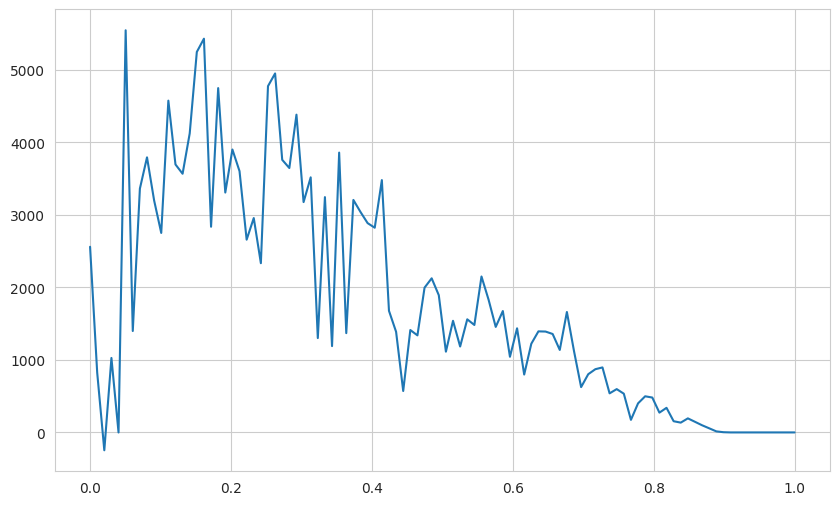

In [23]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(np.linspace(0, 1, 100), mean_profits)
plt.show()

In [154]:
# best_profit, best_threshold = 0.0, 0.0
# mean_profits, mean_revenues = [], []
# mean_precisions, mean_recalls = [], []
#
# empty_stat_dict = {
#     'mean_revenue': 0,
#     'mean_profit': 0,
#     'mean_precision': 0,
#     'mean_recall': 0
# }
# stats_dict = {t: empty_stat_dict.copy() for t in np.linspace(0, 1, 100)}
#
# revenues, profits = [], []
# precisions, recalls = [], []
#
# for train_ind, test_ind in kf.split(X):
#     X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
#     y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
#
#     pipe_lr.fit(X_train, y_train)
#     proba = pipe_lr.predict_proba(X_test)[:, 1]
#
#     for threshold in np.linspace(0, 1, 100):
#         predict = np.where(proba > threshold, 1, 0)
#         revenue = ((predict == 1) & (predict == y_test)).sum()
#         client_income = np.random.uniform(0, 20, revenue.shape)
#         revenue *= client_income
#         revenues.append(revenue)
#         profits.append(revenues[-1] - predict.sum())
#         precisions.append(precision_score(y_test, predict))
#         recalls.append(recall_score(y_test, predict))
#
#         mean_revenues.append(np.mean(revenues))
#         mean_profits.append(np.mean(profits))
#         mean_precisions.append(np.mean(precisions))
#         mean_recalls.append(np.mean(recalls))
#
#         stats_dict[threshold]['mean_revenue'] += mean_revenues[-1]
#         stats_dict[threshold]['mean_profit'] += mean_profits[-1]
#         stats_dict[threshold]['mean_precision'] += mean_precisions[-1]
#         stats_dict[threshold]['mean_recall'] += mean_recalls[-1]
#
#
# best_mean_profit, best_threshold = 0.0, 0.0
#
# for threshold, stat in stats_dict.items():
#     stat['mean_revenue'] /= 100
#     stat['mean_profit'] /= 100
#     stat['mean_precision'] /= 100
#     stat['mean_recall'] /= 100
#
#     if best_mean_profit < stat['mean_profit']:
#         best_mean_profit = stat['mean_profit']
#         best_threshold = threshold
#
# print(f'Best threshold found by CV: {best_threshold}')
# print(f'Best mean profit: {best_profit}')

/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Best threshold found by CV: 0.020202020202020204
Best mean profit: 0.0


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [152]:
threshold = 0.172

revenues, profits = [], []
precisions, recalls = [], []

for train_ind, test_ind in kf.split(X):
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    pipe_lr.fit(X_train, y_train)
    proba = pipe_lr.predict_proba(X_test)[:, 1]
    predict = np.where(proba > threshold, 1, 0)

    client_income = np.random.uniform(0, 20)
    revenues.append(client_income * ((predict == 1) & (predict == y_test)).sum())
    profits.append(revenues[-1] - predict.sum())
    precisions.append(precision_score(y_test, predict))
    recalls.append(recall_score(y_test, predict))

mean_revenue = np.mean(revenues)
mean_profit = np.mean(profits)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

std_revenue = np.std(revenues)
std_profit = np.std(profits)
std_precision = np.std(precisions)
std_recall = np.std(recalls)


print(f'Mean revenue: {mean_revenue}; revenue standard deviation: {std_revenue}')
print(f'Mean profit: {mean_profit}; profit standard deviation: {std_profit}')
print(f'Mean precision: {mean_precision}; precision standard deviation: {std_precision}')
print(f'Mean recall: {mean_recall}; recall standard deviation: {std_recall}')


Mean revenue: 4800.745937137104; revenue standard deviation: 2396.9942151262767
Mean profit: 3458.745937137104; profit standard deviation: 2397.5875115452036
Mean precision: 0.4066612185360228; precision standard deviation: 0.013436109236979509
Mean recall: 0.5882453197930222; recall standard deviation: 0.020386426107105733


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [29]:
precisions, recalls = [], []
for stat in stats:
    if stat['mean_recall'] >= 0.5:
        precisions.append(stat['mean_precision'])
        recalls.append(stat['mean_recall'])

precisions, recalls = np.array(precisions), np.array(recalls)

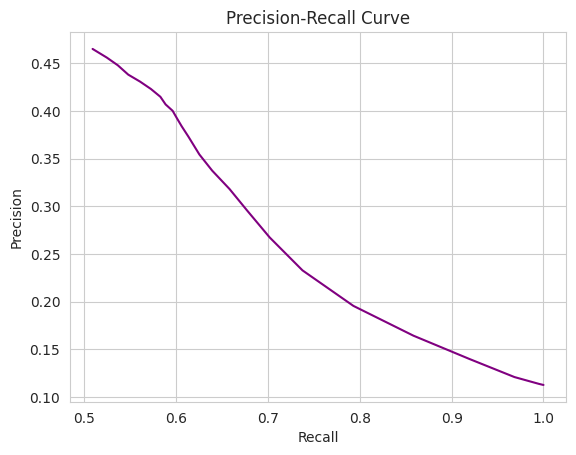

In [30]:
fig, ax = plt.subplots()
ax.plot(recalls, precisions, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

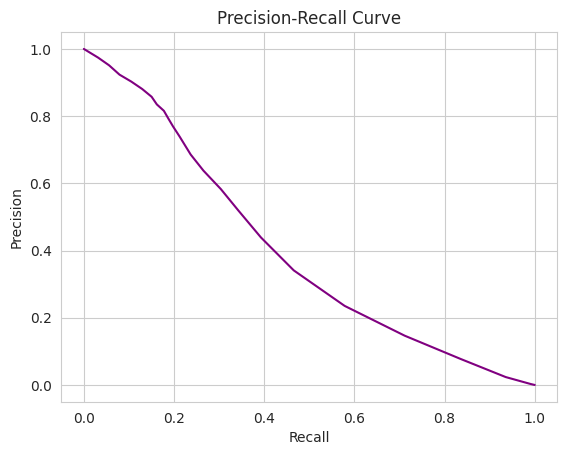

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
precisions = scaler.fit_transform(precisions.reshape(-1, 1))
recalls = scaler.fit_transform(recalls.reshape(-1, 1))

fig, ax = plt.subplots()
ax.plot(recalls, precisions, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

In [32]:
print(f'AUC PR = {auc(recalls, precisions)}')

AUC PR = 0.4008443745490511


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ редбулл с пончиком из местного самокатa $___$